In [13]:
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np


data_dict = pickle.load(open('./data.pickle', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier(max_depth=5, random_state=0)

model.fit(x_train, y_train)

y_predict = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_predict)
print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))

# Perform cross-validation to assess generalization performance
cv_scores = cross_val_score(model, data, labels, cv=5)
print('Cross-Validation Scores: {}'.format(cv_scores))
print('Mean CV Accuracy: {:.2f}%'.format(np.mean(cv_scores) * 100))

f = open('model_trial.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

Test Accuracy: 97.66%
Cross-Validation Scores: [0.9765625  0.98828125 0.99023438 0.97851562 0.9765625 ]
Mean CV Accuracy: 98.20%


In [15]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
 
# Precision
precision = precision_score(y_test, y_predict, average='weighted')
print("Precision: ", precision)

# Recall
recall = recall_score(y_test, y_predict, average='weighted')
print("Recall: ", recall) 

# F1 Score
f1 = f1_score(y_test, y_predict, average='weighted')
print("F1 Score: ", f1)





Precision:  0.9608414938556067
Recall:  0.9765625
F1 Score:  0.9671845109995217


c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk

# Load the hand gesture recognition model
model_dict = pickle.load(open('./model_trial.p', 'rb'))
model = model_dict['model']

root = tk.Tk()
root.title("Hand Gesture Recognition")
root.geometry("1100x1000")

# Create a canvas to display the webcam feed
canvas = tk.Canvas(root, width=600, height=600)
canvas.pack()

predicted_label = tk.Label(root, text="Predicted Character: ", font=("Helvetica", 16))
predicted_label.pack()

save_text = tk.Label(root, text="Word: ", font=("Helvetica", 16))
save_text.pack()


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# Define labels for hand gestures
labels_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M',
               12: 'N', 13: 'O', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'U', 19: 'V', 20: 'W', 21: 'X', 22: 'Y',
               23: 'THUMBS_UP', 24: 'HEART', 25: 'SUPER'}

# Function to process webcam frames and perform hand gesture recognition
def process_frame():
    ret, frame = cap.read()
    if ret:
        H, W, _ = frame.shape
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(frame_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            data_aux = []
            x_ = []
            y_ = []

            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

            x1 = int(min(x_) * W) - 10
            y1 = int(min(y_) * H) - 10

            x2 = int(max(x_) * W) - 10
            y2 = int(max(y_) * H) - 10

            prediction = model.predict([np.asarray(data_aux)])
            predicted_character = labels_dict[int(prediction[0])]
            predicted_label.config(text="Predicted Character: " + predicted_character)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
            cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3,
                        cv2.LINE_AA)

        # Convert the frame to a format that can be displayed by Tkinter
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.img = img

        # Call this function again after a delay
        root.after(30, process_frame)
word = "" 
def save_letter():
    global word
    predicted_character = predicted_label.cget("text").split()[-1]  # Get the predicted character from the label
    word+=predicted_character
    if len(word) > 0:  # Save the letter if it's a single character 
        save_text.config(text="Word: " + word)
       
def save_word():
    global word
    if len(word) > 0:
        # Save the entire word to the file and reset the word variable
        with open("letters.txt", "a") as f:
            f.write(word + "\n")  # Write the word to the file
        
        # Reset the word variable and update the save_text label
        word = ""
        save_text.config(text="Word: " + word)

def clear():
    save_text.config(text="Word: " )
    global word
    word=""
    
# Start capturing from the webcam
cap = cv2.VideoCapture(0)

# Call the function to start processing frames
process_frame()

# Button to save the predicted character
save_button = tk.Button(root, text="Save Letter", command=save_letter,bd=2, padx=10, pady=5)
save_button.pack()

clear_button = tk.Button(root,text="clear",command=clear,bd=2, padx=10, pady=5)
clear_button.pack()

# Run the Tkinter event loop
root.mainloop()

# Release the video capture and close all windows when done
cap.release()
cv2.destroyAllWindows()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 839, in callit
    func(*args)
  File "C:\Users\samip\AppData\Local\Temp\ipykernel_14328\1490637917.py", line 76, in process_frame
    prediction = model.predict([np.asarray(data_aux)])
  File "c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 905, in predict
    proba = self.predict_proba(X)
  File "c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 947, in predict_proba
    X = self._validate_X_predict(X)
  File "c:\Users\samip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 641, in _validate_X_predict
    X = self._validate_data(
  

In [29]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000126C71A2B30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000126C8A74A00>})

In [30]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 179}


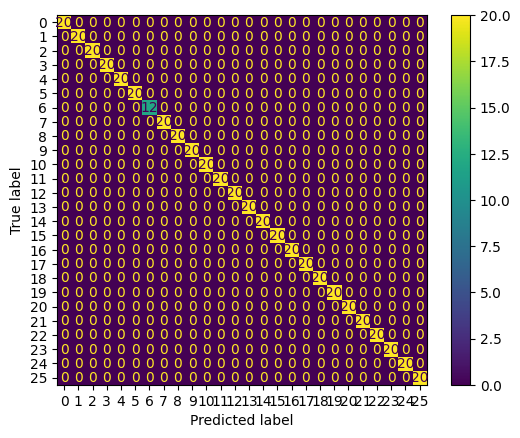

In [32]:
# Generate predictions with the best model
y_pred = best_rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'knn' is not defined